# DatasetMake

Here, I endeavor to assemble a suitable testing document. This testing document will be a random selection of documents from our corpus, but it will not be a _uniform_ random selection. Unique pages will be enriched by a known, quantifiable amount. The intent of selecting pages that are observed to be "unique" is to:
1. Represent as many _languages_ as possible that feature reasonably prominently in the dataset.
    * No language (e.g., all pictures) is one possibility here.
1. Represent all _page orientations_ that feature reasonably prominently in the dataset, possibly including:
    * 0 degrees
    * 90 degrees
    * 180 degrees
    * 270 degrees
    * None of the above
1. Represent all exceptional elements that feature reasonably prominently in the dataset, possibly including:
    * Presence of at least one image
    * Presence of tabular data

In this case, "reasonably prominently" means "with high enough frequency as to have a non-negligible effect on overall OCR accuracy."

I also endeavor to quantify the frequency of these characteristics for the following reasons:
* It is necessary to determine which circumstances feature "reasonably prominently."
* More importantly, it is necessary to determine the magnitude of the effect of any bug on our OCR output. This will make our accuracy metrics more meaningful.

Here, I handle imports:

In [1]:
!pip install PyMuPDF
!pip install -U -q PyDrive

     |████████████████████████████████| 6.4MB 7.3MB/s 


Here, initialize drive access:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.settings import InvalidConfigError
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here, I import needed packages:

In [3]:
import fitz
from shutil import copyfile
import os
import numpy as np
import pandas as pd
import time
import gspread
from oauth2client.client import GoogleCredentials
from google.colab import auth

Here, I declare global variables and utility functions:

In [4]:
CATALOG_NAMES = [
  'catalog.20200407.aa', 'catalog.20200407.ab', 'catalog.20200407.ac',
  'catalog.20200407.ad', 'catalog.20200407.ae'
]
LARGE_SAMPLE_PATH = ('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/'
                     'awca-ocr/large_sample.pdf')
COMPRESSED_SAMPLE_PATH = ('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/'
                          'pDonovan/awca-ocr/compressed_sample.pdf')
CORPUS_ROOT = '/content/drive/MyDrive/AWCA/PDFtp'
WORKING_DIR = ('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/'
               'pDonovan/awca-ocr/temp')

In [5]:
def get_df(title, gc, worksheet=0, has_headers=True):
    """Returns a pandas.DataFrame representation of the
    (WORKSHEET)th worksheet of the Google Sheets (GSHEET)
    file that has title TITLE.
    TITLE - the title of the desired spreadsheet
    GC    - the GSpread credentials needed to retrieve the spreadsheet
    WORKSHEET - the index of the desired worksheet within
        the spreadsheet
    HAS_HEADERS - set to False if the spreadsheet does not
        have a header row at the top.
    It is not necessary to specify the path or the GSHEET
    file extension. Note that this creates undefined
    behavior when your google drive has multiple spreadsheets
    with the same name (i.e., you do not know which one
    will be opened).
    """
    # For details on how to handle GSHEET files, see
    # https://gspread.readthedocs.io/en/latest/api.html
    contents = gc.open(title).get_worksheet(worksheet).get_all_values()
    if has_headers:
        return pd.DataFrame.from_records(
            data=contents[1:],
            columns=contents[0]
        )
    return pd.DataFrame.from_records(contents)

In [6]:
auth.authenticate_user()
GC = gspread.authorize(GoogleCredentials.get_application_default())

In [7]:
CATALOG = pd.concat(
    (get_df(name, GC) for name in CATALOG_NAMES),
    ignore_index=True
)
CATALOG.head()

,ID,md5,Size,mime-type,Created Date,Modified Date,Folder,Name,gdoc-id,gdoc-url,gdoc-length,gdoc-exceptions,gdoc-timestamp,delta-t (s),Notes
0,0BwjSAKD6JzR6WXBVczdtRVBuVG8,c2bbbcdb46850c82a6f0639122da65b3,43036522,video/quicktime,2017-03-06T21:54:39.618Z,2017-03-06T21:54:39.618Z,ane.pdf.share/By Topic (or field)/Teaching Tools,Flex Search Workspace.mov,,,,,,,
1,0ByFFNduW4doJWUhIQmhqQ0ZCbnM,4b182737a83195784fccbbd2c2532e5a,11711124,video/quicktime,2013-01-31T00:48:04.693Z,2013-01-31T00:48:04.693Z,ane.pdf.share/By Topic (or field)/Teaching Too...,V22i3003 -ls T718 dM ls rain movie.MOV,,,,,,,
2,0ByFFNduW4doJSlZYZTdCTG1oa0E,4b182737a83195784fccbbd2c2532e5a,11711124,video/quicktime,2013-01-31T00:48:46.458Z,2013-01-31T00:48:46.458Z,ane.pdf.share/By Topic (or field)/Teaching Too...,V22i3003 -ls T718 dM rain movie.MOV,,,,,,,
3,0ByFFNduW4doJWThDMC15Nm1Ucms,0b760c00c95eb567b91f195a6f6badba,11831672,video/quicktime,2013-01-31T00:49:32.192Z,2013-01-31T00:49:32.192Z,ane.pdf.share/By Topic (or field)/Teaching Too...,V22i3004 -ls T718 dM draining movie.MOV,,,,,,,
4,0ByFFNduW4doJT0lDUFdSeEdRdkU,0b760c00c95eb567b91f195a6f6badba,11831672,video/quicktime,2013-01-31T00:50:18.413Z,2013-01-31T00:50:18.413Z,ane.pdf.share/By Topic (or field)/Teaching Too...,V22i3004 -ls T718 dM ls draining movie.MOV,,,,,,,


In [8]:
CATALOG.shape

(530285, 15)

In [9]:
CATALOG.sample(5)

,ID,md5,Size,mime-type,Created Date,Modified Date,Folder,Name,gdoc-id,gdoc-url,gdoc-length,gdoc-exceptions,gdoc-timestamp,delta-t (s),Notes
447832,1a4-N2ZvdLt8rifeJiofi3Lh3cBRxIne0,bbe7fceff80c3cef202a3e0b95072691,4096,application/pdf,2019-07-21T19:57:21.259Z,2019-07-21T19:57:21.259Z,ane.pdf.share/To be sorted.../EDUB2BAA/Strahil...,._Tadmor - 1958 (JNES 17) - dâku.pdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325064,11T3axPel0nZHz0cl-6oRmaGNB76fwJhr,e8f853891669e605350e1925005d9298,625557,application/pdf,2019-07-02T09:06:02.370Z,2019-07-02T09:06:02.370Z,ane.pdf.share/To be sorted.../EDUB2BAA/C Anato...,4 Review of Excavations at Tepe Gawra volume I...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
462357,16Vogm4-awQ80zyns-N_OkKTx9UEhc1Gw,dff1ab7e624ed29ef901d54c376fb226,159911,image/jpeg,2019-07-22T05:13:02.896Z,2019-07-22T05:13:02.896Z,ane.pdf.share/To be sorted.../EDUB2BAA/Strahil...,S1445.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304048,1ku_FlVb3ZAMlJFLuCRDfHB1yfiktKJiX,3b58e575402eab28593a32feb2f32ad3,188383,application/pdf,2019-07-03T07:58:32.613Z,2019-07-03T07:58:32.613Z,ane.pdf.share/To be sorted.../EDUB2BAA/Bit Enk...,"Iraq 25, Kupper, Opinion publique Mari.pdf",NaN,NaN,NaN,NaN,NaN,NaN,NaN
506432,1zdPPCyTaqeJyJSYjTVJLT16ard6gVtgN,1,1,application/vnd.google-apps.folder,2019-08-16T22:57:24.383Z,2019-08-16T22:57:24.383Z,ane.pdf.share/To be sorted.../EDUB2BAA/Willis/...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Build a Large Representative Document

The objective here is simply to take a uniform random sample of pages and to stitch them all into one PDF for easy reference.

I am aware that `sample_pdfs` is not good code. It is only intended to be run once. Please don't maintain it.

In [10]:
def sample_pdfs(catalog, n, root, working_dir, random):
  """Returns an iterable of N paths to copies of PDF files selected
  uniformly at random from CATALOG.
  """
  pdfs = catalog[
    (catalog['mime-type'] == 'application/pdf')
    & np.array([name[:2] != '._' for name in catalog.Name])
  ]
  # The exact value 1e9 is unimportant -- it is not a magic number.
  pdfs = pdfs.sample(n, random_state=random.integers(1e9), replace=True)
  pdfs.index = list(range(len(pdfs.index)))
  original_paths = pdfs.apply(
      (lambda row: os.path.join(root, row.Folder, row.Name)),
      axis=1,
  )
  new_paths = pdfs.apply(
      (lambda row: (os.path.join(working_dir, row.ID) + '.pdf')),
      axis=1
  )
  paths = list()
  for idx in original_paths.index:
    while True:
      try:
        print('DEBUG: ', idx, ', ', new_paths[idx])
        if os.path.exists(new_paths[idx]):
          print('DEBUG: found PDF at ', new_paths[idx])
          paths.append(new_paths[idx])
        elif os.path.exists(original_paths[idx]):
          print('DEBUG: found PDF at ', original_paths[idx])
          paths.append(original_paths[idx])
        else:
          drive.CreateFile({'id': pdfs.loc[idx, 'ID']}).GetContentFile(new_paths[idx])
          print('DEBUG: created PDF at ', new_paths[idx])
          paths.append(new_paths[idx])
        break
      except Exception as e:
        print('DEBUG: ', e)
        auth.authenticate_user()
        GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        GoogleDrive(gauth)
  return paths

In [55]:
def combine(pdfs, output_path, random):
  """Writes a document to OUTPUT_PATH with one page selected
  uniformly at random from each document in PDFS.
  :param pdfs: an iterable of paths to PDF files
  :param output_path: the path to the file to be written
  :param random: a numpy.random.Generator instance
  """
  out = fitz.open()
  pdfs = list(pdfs)
  errors = list()
  for i, path in enumerate(pdfs):
    try:
      pdf = fitz.open(path, filetype='pdf')
      assert len(pdf) > 0, 'PDF must have at least one page.'
    except Exception as e:
      errors.append(str(e))
      print(e)
      continue
    chosen = int(random.integers(len(pdf)))
    print('{} DEBUG: Selecting page {} from {}'.format(i, chosen, path))
    out.insert_pdf(pdf, from_page=chosen, to_page=chosen)
  print('Terminated with {} errors.'.format(errors))
  out.save(output_path)
  return errors

In [56]:
random = np.random.default_rng(333) # Time of day when this code was written
combine(
    sample_pdfs(CATALOG, 1600, CORPUS_ROOT, WORKING_DIR, random),
    LARGE_SAMPLE_PATH, random
)

DEBUG:  0 ,  /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1T5zmjoa2zcBkiIu6vbpoxcGmoFmS7ZqO.pdf
DEBUG: found PDF at  /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1T5zmjoa2zcBkiIu6vbpoxcGmoFmS7ZqO.pdf
DEBUG:  1 ,  /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1CpervdsqrDmIOuEprs2woDBKiIgTwCDi.pdf
DEBUG: found PDF at  /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1CpervdsqrDmIOuEprs2woDBKiIgTwCDi.pdf
DEBUG:  2 ,  /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1MHzaehYGC-RwqCfrSIrB3cnQo6Guuy2c.pdf
DEBUG: found PDF at  /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1MHzaehYGC-RwqCfrSIrB3cnQo6Guuy2c.pdf
DEBUG:  3 ,  /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/0ByFFNduW4doJZFdBRkRTa0dlM3c.pdf
DEBUG: found PDF at  /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Univ Presses/Oxford Univ Press/0195393

mupdf: expected trailer marker
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict


106 DEBUG: Selecting page 6 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1RYJaBUAb5xS5t7VDjiXdK4rmaqqiy-zR.pdf
107 DEBUG: Selecting page 240 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1BbERM8OTfrKsB4aAsUgGHFb0pbb1AQ1d.pdf
108 DEBUG: Selecting page 10 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1ur6vuunbBT474-YexKMBq_V3TmvNTjv4.pdf
109 DEBUG: Selecting page 487 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/B/B/Bright, John - A History of Israel, 4th Edition. 2000.pdf
110 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1XuQiwz_S_nikQcC2DkuB6uvTAlEEQWll.pdf
111 DEBUG: Selecting page 2 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1ZsuKPkhrRokotnS8-LlGkEYPmCq87yWT.pdf
112 DEBUG: Selecting page 11 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1aaGfc5xmJOHC4S

mupdf: expected trailer marker
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict


169 DEBUG: Selecting page 3 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1pXHU7U6m2QJfr2_sJGDEK0rz5zDBi1OF.pdf
170 DEBUG: Selecting page 7 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1Oqk5VjKpkpy6IqB7RoykfiOfDkdaRiLO.pdf
171 DEBUG: Selecting page 50 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Periodical/Sumer/Sumer Separata/المجلد الخامس و العشرون، 1969 - الجزء 1 و 2/noormags-Nineveh_The_1968_-_1969_Campagn.pdf
172 DEBUG: Selecting page 5 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1ShUR4ok7l2utFBH8pXD7LfCnNgQVl5PN.pdf
173 DEBUG: Selecting page 4 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1nE9H50mtPDhNKkMrgNCbZr9YDXOuNYM1.pdf
174 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Dissertations/Studies in ancient Anatolian language and culture (Turkey) by Taylor, Patrick John.pdf
175 DEBUG: Selecting pag

mupdf: cannot recognize version marker
mupdf: no objects found


401 DEBUG: Selecting page 2 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Festschriften/Fs Neumann = GVL 17/Janda_FsNeumann2.PDF
402 DEBUG: Selecting page 8 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1KR3AyoAxFGnQ5WfoMGm51_8X4nKeOE-U.pdf
403 DEBUG: Selecting page 22 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1X_uGWWnuVZotcPbzdCNGlDE7FQckPrQ1.pdf
404 DEBUG: Selecting page 142 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Periodical/JNES/jnes55.pdf
405 DEBUG: Selecting page 6 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Area Studies/Библиотека/Hebrew language/History of Hebrew Grammatical Thought/Karaite grammar/מאור עין/געש. צירופים של חלקי הדיבר היכולים להעמיד מבע עצמאי לפי החיבור הדקדוקי הקראי מאור עין.pdf
406 DEBUG: Selecting page 7 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/17r_T9koJWuBLv6Iw64yuIttvbDWXZkMJ.pdf
407 DEBUG:

mupdf: cannot recognize version marker
mupdf: cannot tell in file


441 DEBUG: Selecting page 136 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/18tHG4Uczn3J1Pu_4uNM6ZcMwcHFAknZz.pdf
442 DEBUG: Selecting page 3 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1yiJRPPgN8lVofcbNJypMcLAcVjavp10e.pdf
443 DEBUG: Selecting page 12 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/16IKOKH2O0SJY1lJrzTQxd0acDHTYoxR-.pdf
444 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/B/B/burkert-von ullikummi zum kaukasus, zur kontinuität einer mündlichen erzählung (2).pdf
445 DEBUG: Selecting page 230 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Univ Presses/Cambridge Univ Press/0521821320.Cambridge.University.Press.Reading.the.Past.Current.Approaches.to.Interpretation.in.Archaeology.Jan.2004.pdf
446 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1BtHlPnoZZtwIyQT

mupdf: cannot find startxref
mupdf: invalid key in dict
mupdf: expected trailer marker


501 DEBUG: Selecting page 1 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1zx6dgb8QpAgKpBwz0Qt_v7lJraSHptN4.pdf
502 DEBUG: Selecting page 396 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Series (or encyclopedia)/Encyclopedias & Companions/Cambridge History/Cambridge_History_of_Judaism_3.pdf
503 DEBUG: Selecting page 3 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1uVC5W_zRouo_1S7pmv1iRvv0Z0z2JsTi.pdf
504 DEBUG: Selecting page 153 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1CyAGLvXcIznHEKIc5wBufHBfvJ2dUvMI.pdf
505 DEBUG: Selecting page 11 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1-tGMAB56r6p_i7jKBBxfuVWHXyDoD0CQ.pdf
506 DEBUG: Selecting page 6 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1TnHSvyQmRrchivpyuU0Y6HJQYvdAiNTz.pdf
507 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-o

mupdf: cannot recognize version marker


645 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1KcAZpDFHa8H6lklYPb-1-PKieWjoBhtk.pdf
646 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1F0Uu8tUU1yGTXGSrNYAwd0E8jPaJ-4ID.pdf
647 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1AU2iprjpy9U49b9gCSjtUpbqnf2gznQ_.pdf
648 DEBUG: Selecting page 5 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Periodical/ArAn (Archivum Anatolicum-Anadolu Arşivleri)/2 Pdf/04 GÜNBATTI, Cahit, Two New Tablets Throwing Light on the Relations Between Anatolian Kings and Assyrian Merchants in the Period of the Assyrian Colonies.pdf
649 DEBUG: Selecting page 42 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Series (or encyclopedia)/TC/TC_3.3.pdf
650 DEBUG: Selecting page 101 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Series (or encyclopedia)/HdO/HdO 28 Sivan, Daniel - Ugarit

mupdf: expected trailer marker


747 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1Nv8H8jZbDJFBLxvP6KDwfu71lyPpjbz4.pdf
748 DEBUG: Selecting page 34 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1zy0D-TyNq4HTDzm6D60r4M81-8MSg8jx.pdf
749 DEBUG: Selecting page 87 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/T/Taleb - The Black Swan.pdf
750 DEBUG: Selecting page 22 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Site Reports/Israel/Farah N/Mallet, J. -Tell el-Farah II,1 - Le Bronze Moyen.pdf
751 DEBUG: Selecting page 97 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1IoMs8IGEzlGM9V3FJLDJ2Ffklj8K82Xe.pdf
752 DEBUG: Selecting page 290 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1XNIvnF-RKK5G_HqalEJCiaZbQNQJgsdg.pdf
753 DEBUG: Selecting page 6 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/14OQcebr

mupdf: cannot recognize version marker
mupdf: cannot tell in file


815 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1XIXNGEct5okKt5kfh54FldQg9yyHUU7h.pdf
816 DEBUG: Selecting page 8 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1Rn5kEF30PZqPxDkTZGYUASqDxipLp6rP.pdf
817 DEBUG: Selecting page 2 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1i0pMhmEDnuyziJWqTDvoxBfO4YQgc7A7.pdf
818 DEBUG: Selecting page 1 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1F___wvvn8F5eVVXcgUERsZxrhGkW2jmS.pdf
819 DEBUG: Selecting page 191 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1W34anOVt8fw7GC6_YtpWTUKVb6WMWBU9.pdf
820 DEBUG: Selecting page 9 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1wdwkqPgLiQHABRN2UVwCb_CVr3ebF4DG.pdf
821 DEBUG: Selecting page 256 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1IgOY7iaD5BJ3HlQ3tNTZ8I7qU2HZM78V.pdf
82

mupdf: expected trailer marker


911 DEBUG: Selecting page 42 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1zP0wHwlNXaBY4NLk8CD_UFw3pJ-dHWIq.pdf
912 DEBUG: Selecting page 3 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1zKb9d5_lFwZuQ4azf3HGB9mF52vAIMES.pdf
913 DEBUG: Selecting page 71 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Series (or encyclopedia)/VS/VAS-26_bis.PDF
914 DEBUG: Selecting page 188 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1EmApUd80mIPuK2MQfgQe2ibx0goO19_T.pdf
915 DEBUG: Selecting page 10 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Teaching Tools/ANE Shared Files/Archeologie/Artikel/A/Astour_1972.pdf
916 DEBUG: Selecting page 2 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1WARaSylc2dVmQltn3sowLEPY2NzMYVi3.pdf
917 DEBUG: Selecting page 13 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/R/R (dirty)/ronchi1.PDF
9

mupdf: cannot find startxref
mupdf: zlib error: incorrect header check
mupdf: corrupt object stream (2244 0 R)
mupdf: zlib error: incorrect header check
mupdf: corrupt object stream (2245 0 R)
mupdf: zlib error: incorrect header check
mupdf: corrupt object stream (2246 0 R)
mupdf: zlib error: incorrect header check
mupdf: corrupt object stream (2247 0 R)
mupdf: zlib error: incorrect header check
mupdf: corrupt object stream (2248 0 R)


960 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Area Studies/Библиотека/Hebrew language/Biblical Hebrew/Dictionaries/מנדלקרן – קונקורדנצייה לתנך/תיקונים לתיקונים לקונקורדנציה של מנדלקרן.pdf
961 DEBUG: Selecting page 11 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1KzclGgM_kc0p9kvPPd9Zf56aPENxywQB.pdf
962 DEBUG: Selecting page 12 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/B/Bar-Yosef and Zilhao 2006 Towards a Definition of the Aurignacia.pdf
963 DEBUG: Selecting page 92 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Area Studies/Egypt/Coptic/Coptic_CSSC_2_Leipoldt_1908.PDF
964 DEBUG: Selecting page 7 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1z1UlGU-HFe0A13Ni7mHdTscCT1i5WveN.pdf
965 DEBUG: Selecting page 3 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1L8jxfHQmsdw8aKTTEsqf94td01fnyTRX

mupdf: expected object number


mupdf: No default Layer config


980 DEBUG: Selecting page 35 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1ea6kepHzvfIdJGNfSDL-qzKvch9iK7P2.pdf
981 DEBUG: Selecting page 3 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/0B9Ibqa26YXiRT1d0c0E4TEFhS2s.pdf
982 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/12H7A1nCSGRqJ6QbSpgfY8zw792ZwVLY8.pdf
983 DEBUG: Selecting page 30 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/S/Snell, Daniel C. ed - A Companion to Ancient Near East [Blackwell, 2005].pdf
984 DEBUG: Selecting page 19 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1xApIQ5Zu0S0Id2ot_iYZ9jqFkAM7KkvE.pdf
985 DEBUG: Selecting page 2 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1hzBMwHx6rSiah1cqgtFmETwb_rie7UeI.pdf
986 DEBUG: Selecting page 15 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1qTfm

mupdf: expected trailer marker


1006 DEBUG: Selecting page 292 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Area Studies/Библиотека/Иудаизм периода II Храма/schaefer_judeophobia-attitudes.toward.the.jews.in.the.ancient.world.pdf
1007 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1h12Uav3Lmgish_tb45bydTR1mRmO-4do.pdf
1008 DEBUG: Selecting page 5 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1wOW9jwom_-BPVitFDhX4_jz-A1J_2bpY.pdf
1009 DEBUG: Selecting page 13 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1NJvOl3p8xBfyEPjNsRHZZV68BIt675UM.pdf
1010 DEBUG: Selecting page 11 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1HKsaXB6pmwSoXpELEiTJHgUsgtU0u177.pdf
1011 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/17_CM_RA5JOZmJyq0AJjnRD2INHbRGzCE.pdf
1012 DEBUG: Selecting page 2 from /content/drive/MyDrive/A

mupdf: expected trailer marker


1035 DEBUG: Selecting page 4 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1n63CD9RN8IiAwsfUmMdHIq16Q1N_XXNw.pdf
1036 DEBUG: Selecting page 25 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1e5aI86e5xuRbNPcHtJ7Ug50C6lMKjuZo.pdf
1037 DEBUG: Selecting page 97 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1GMwdZu1buDmtbDMXbjYkVF2v-8n8oHls.pdf
1038 DEBUG: Selecting page 4 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Area Studies/Assyrian/Old Assyrian/OA Secondary sources/Steiner_1990_UKHB_hattusha_Anitta.pdf
1039 DEBUG: Selecting page 218 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/L/Levinson, Bernard - The Right Chorale, Studies in Biblical Law and Interpretation, 2011.pdf
1040 DEBUG: Selecting page 1 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Periodical/Iraq/Iraq (separata)/Iraq (volumes by year)/Iraq1983/4200195.pdf
1041 DEBUG: 

mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict


1171 DEBUG: Selecting page 183 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1qJsa2uTroNwi0n6OSXsxXRRjwuH4qhys.pdf
1172 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1FOTTHRZb_OhaHttBlMsy2uXP2IBKglgR.pdf
1173 DEBUG: Selecting page 2 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1vXaQnvR9BsPBl6bD02yl8S3d5sL_krja.pdf
1174 DEBUG: Selecting page 19 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Teaching Tools/ANE Shared Files/Old Assyrian/Secondary Sources/rowlandson.PDF
1175 DEBUG: Selecting page 3 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Periodical/SAAB/SAAB Separata/2.2 02 Parpola.pdf
1176 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1IqqNwMJm67BBK4M2JgjuVs5qjVGGgkQn.pdf
1177 DEBUG: Selecting page 60 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1HoAe

mupdf: expected trailer marker


1183 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1S8jcqIrKu2RbKPWpdUfFC-E3m6n4Fl0O.pdf
1184 DEBUG: Selecting page 248 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/11tI6Y99qe3yINAB7LJ9OJCmlVqYsGq5h.pdf
1185 DEBUG: Selecting page 15 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/189PGsXK3tRGFlxQJqnYvo70qbXsCkWgd.pdf
1186 DEBUG: Selecting page 4 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1tfrseg2HiPNNjhkx-aO9tm113jCLsBF_.pdf
1187 DEBUG: Selecting page 9 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1X2lUMLgZj_AiCvatVSHJmSg9hbq7kmtL.pdf
1188 DEBUG: Selecting page 12 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1ZcaH48rlBecdU5KGe-9YVi7ilfvGqSYj.pdf
1189 DEBUG: Selecting page 15 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1t9WqUVe66HvYsfsWSKFFTdRbfUNE9O2

mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict


1324 DEBUG: Selecting page 9 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1_8zURWXwmHfEw3aAT5bwiR6Ug2tMHf4R.pdf
1325 DEBUG: Selecting page 124 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1TYp6UGZtk4QT3o1rgIlxcNqMzFJD5G4h.pdf
1326 DEBUG: Selecting page 6 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1uMCKLlHKiRZFsZhsiaA_Ab5vW0d5Yd94.pdf


mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict


1327 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1AvQfRFlwXZFo0Xds7ci22AbPByqp-j11.pdf
1328 DEBUG: Selecting page 206 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/17IxoBNxwjFmEAYY2ii_lhNJS4E6jCyRH.pdf
1329 DEBUG: Selecting page 1 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/L/Leemans, W.F. - The Trade Relations of Babylonia and the Question of Relations with Egypt in the OB Period. JESHO 3, 1960, pp. 21-37.pdf
1330 DEBUG: Selecting page 1 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1OfCSxawZps-mU6Bmr5jeUGjgreQ4mZEC.pdf
1331 DEBUG: Selecting page 16 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1kKJ2VzF2Yrh5-i-Txv3t_-ayAkA-D_CU.pdf
1332 DEBUG: Selecting page 3 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1r3QNGjeZ24zxiZH01W1MsLLbdlFkfSP0.pdf
1333 DEBUG: Selecting page 10 from /con

mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict


1513 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1yBTQF9oiuNHuF2qdZ45wpTsBIFy57Qal.pdf
1514 DEBUG: Selecting page 17 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1uzguPi8xnS1GcwlFJTG5dYPE3_zad3Ch.pdf
1515 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1BBXISZYhcOlYRdJVkZGRZxi5OB1mLOyT.pdf
1516 DEBUG: Selecting page 14 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1T6ZVAqKUBgDOwhxuvl3YjBWEZOdUDbI6.pdf
1517 DEBUG: Selecting page 17 from /content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Topic (or field)/Area Studies/Egypt/Posener 1951 - La litterature Egyptienne (RdE 6).PDF
1518 DEBUG: Selecting page 0 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1-yme5RI4K-61BWnvws-922djUANOBpZR.pdf
1519 DEBUG: Selecting page 2 from /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1UQ

['no objects found',
 'cannot tell in file',
 'invalid key in dict',
 'cannot tell in file',
 'PDF must have at least one page.']

In [11]:
bert = fitz.open(os.path.join(WORKING_DIR, 'BERT.pdf'))
bert

Document('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/BERT.pdf')

In [12]:
bert.get_page_text(0)

'Proceedings of NAACL-HLT 2019, pages 4171–4186\nMinneapolis, Minnesota, June 2 - June 7, 2019. c⃝2019 Association for Computational Linguistics\n4171\nBERT: Pre-training of Deep Bidirectional Transformers for\nLanguage Understanding\nJacob Devlin\nMing-Wei Chang\nKenton Lee\nKristina Toutanova\nGoogle AI Language\n{jacobdevlin,mingweichang,kentonl,kristout}@google.com\nAbstract\nWe introduce a new language representa-\ntion model called BERT, which stands for\nBidirectional Encoder Representations from\nTransformers. Unlike recent language repre-\nsentation models (Peters et al., 2018a; Rad-\nford et al., 2018), BERT is designed to pre-\ntrain deep bidirectional representations from\nunlabeled text by jointly conditioning on both\nleft and right context in all layers. As a re-\nsult, the pre-trained BERT model can be fine-\ntuned with just one additional output layer\nto create state-of-the-art models for a wide\nrange of tasks, such as question answering and\nlanguage inference, with

In [24]:
bert.get_page_text(0)

'Proceedings of NAACL-HLT 2019, pages 4171–4186\nMinneapolis, Minnesota, June 2 - June 7, 2019. c⃝2019 Association for Computational Linguistics\n4171\nBERT: Pre-training of Deep Bidirectional Transformers for\nLanguage Understanding\nJacob Devlin\nMing-Wei Chang\nKenton Lee\nKristina Toutanova\nGoogle AI Language\n{jacobdevlin,mingweichang,kentonl,kristout}@google.com\nAbstract\nWe introduce a new language representa-\ntion model called BERT, which stands for\nBidirectional Encoder Representations from\nTransformers. Unlike recent language repre-\nsentation models (Peters et al., 2018a; Rad-\nford et al., 2018), BERT is designed to pre-\ntrain deep bidirectional representations from\nunlabeled text by jointly conditioning on both\nleft and right context in all layers. As a re-\nsult, the pre-trained BERT model can be fine-\ntuned with just one additional output layer\nto create state-of-the-art models for a wide\nrange of tasks, such as question answering and\nlanguage inference, with

In [8]:
!sudo apt-get install tesseract-ocr
!pip3 install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,810 kB/s)
debconf: unable to initi

In [9]:
import pytesseract
from PIL import Image

In [10]:
def image(document, page_number, resolution=5):
  pix = document.get_page_pixmap(
      page_number, matrix=fitz.Matrix(resolution, resolution))
  return Image.frombytes(
      ("RGBA" if pix.alpha else "RGB"),
      [pix.width, pix.height], pix.samples
      )

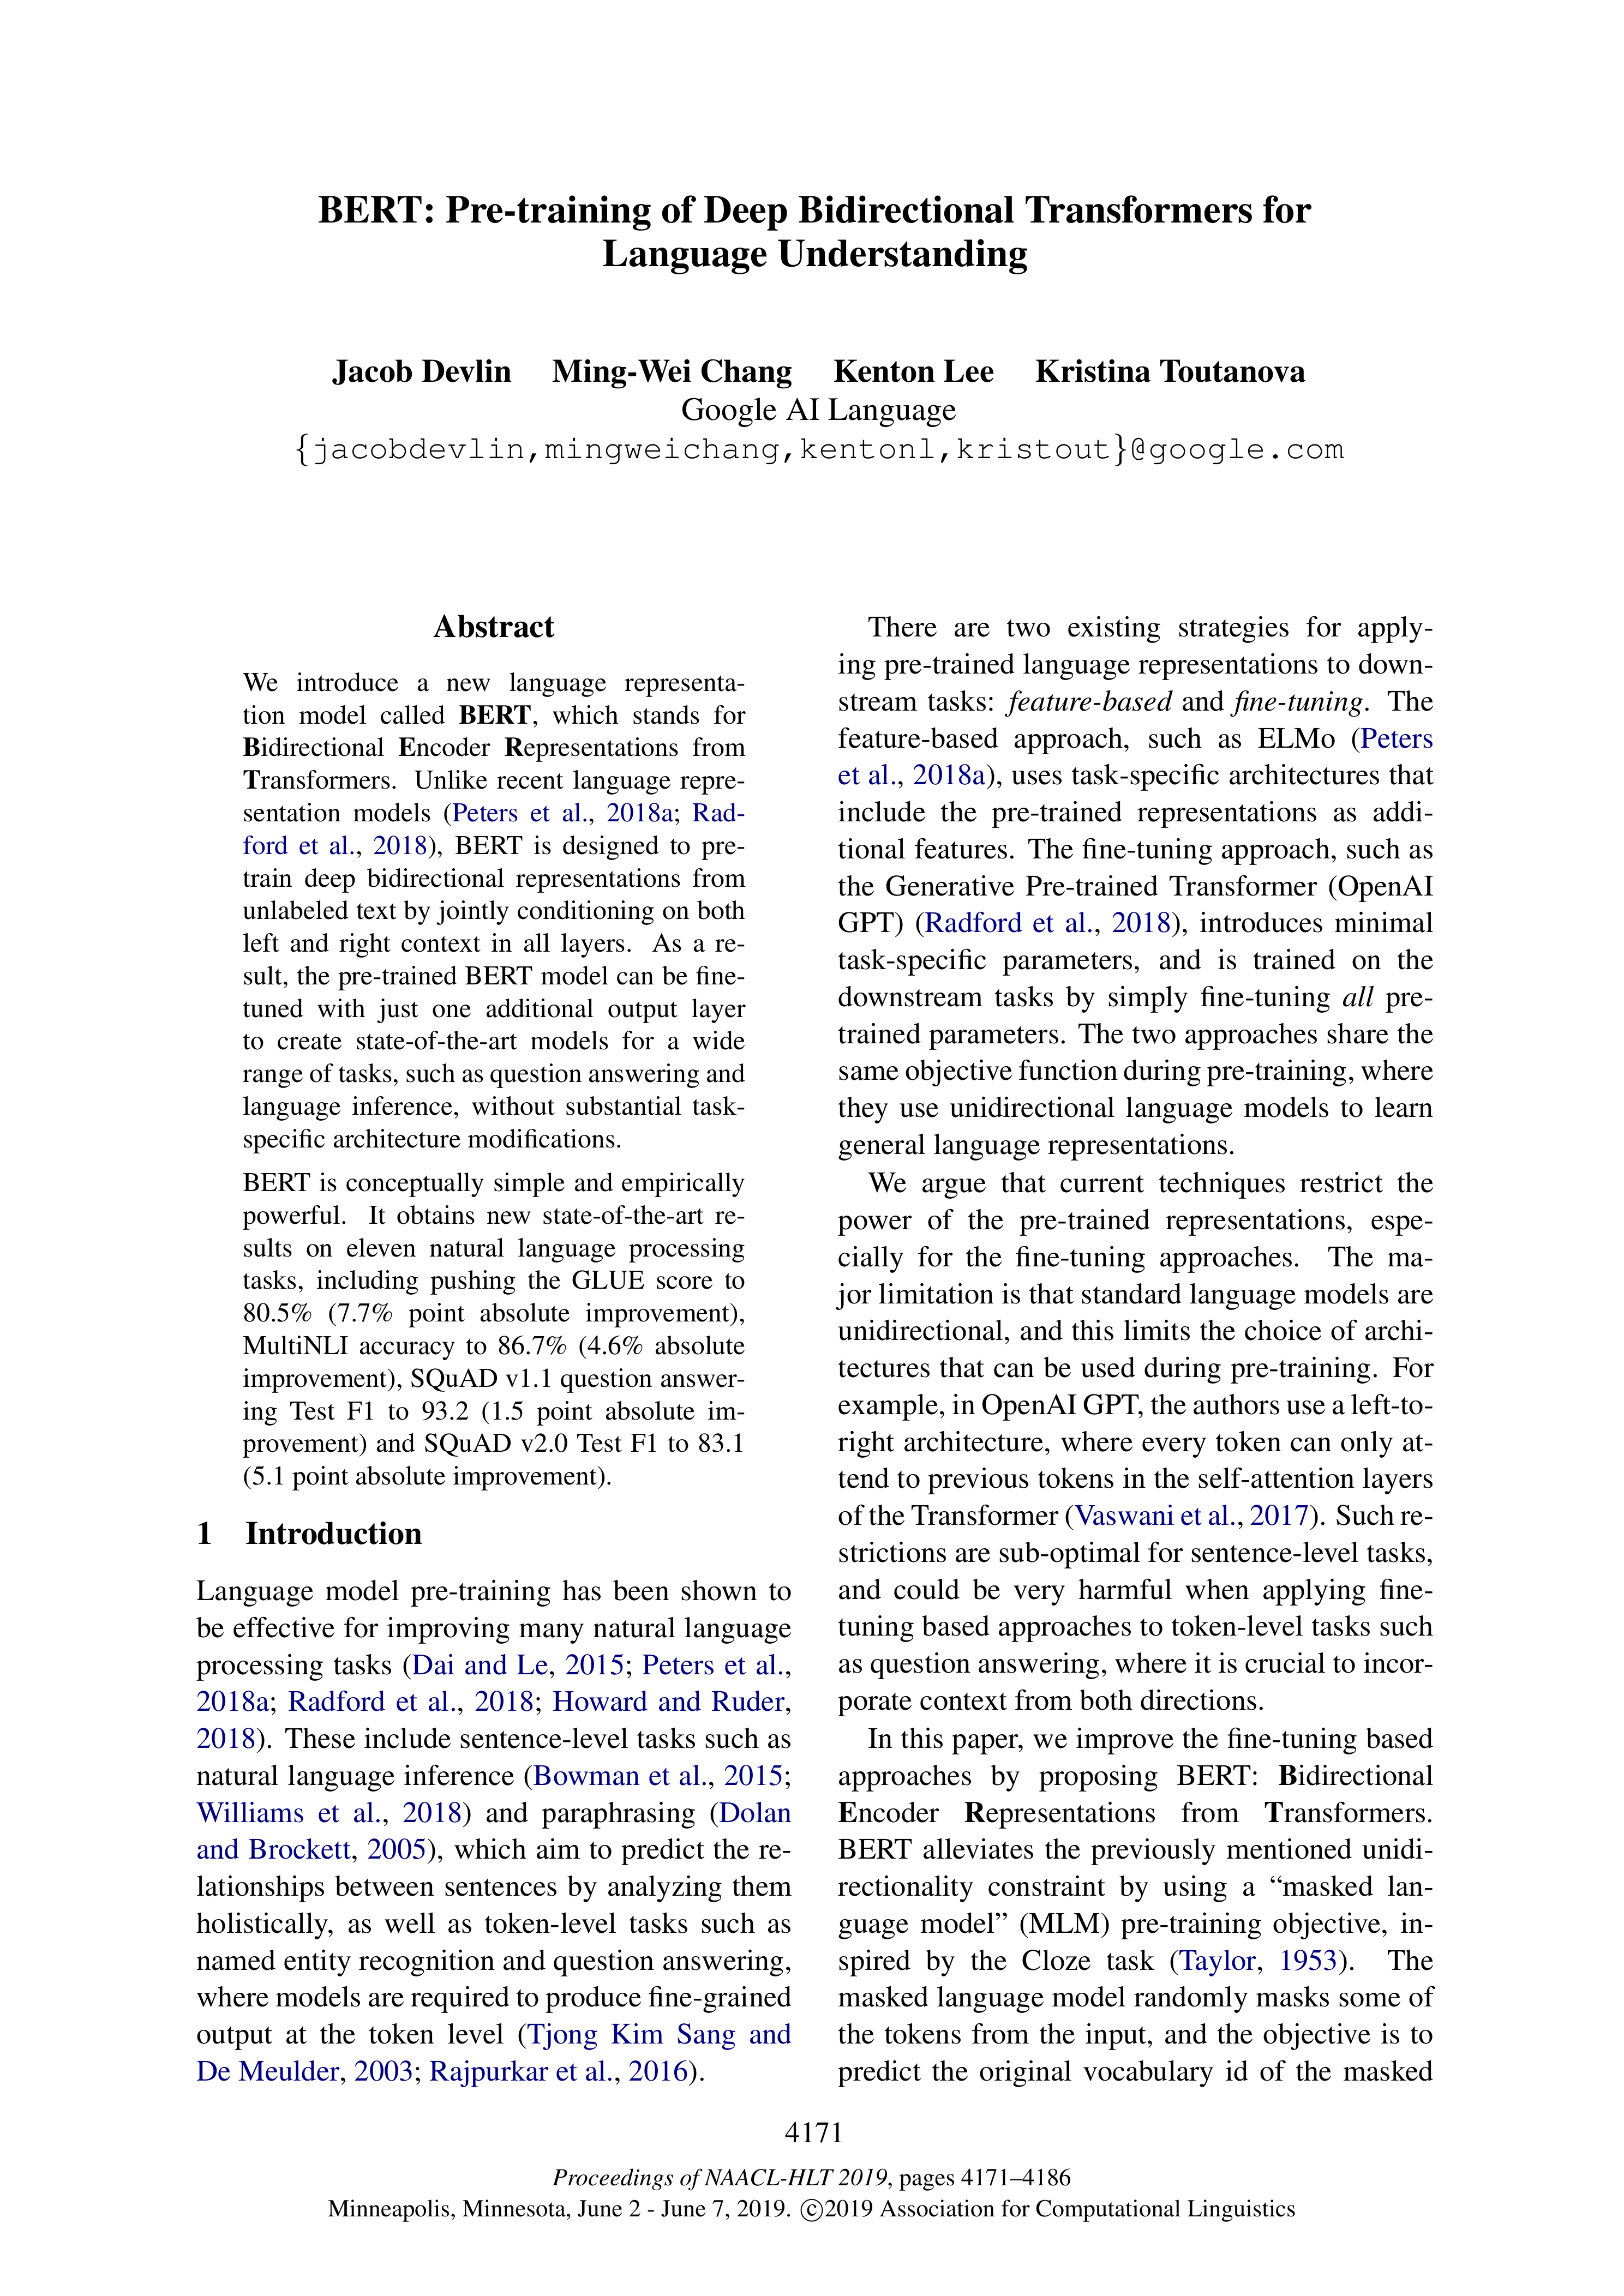

In [28]:
image(bert, 0)

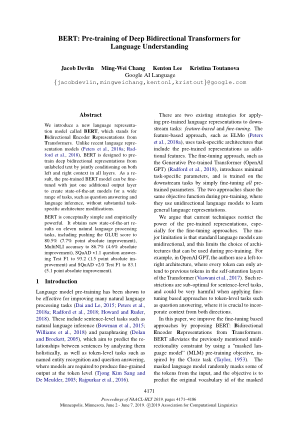

In [29]:
image(bert, 0, 0.5)

In [30]:
image(bert, 0, 10)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
pix = bert.get_page_pixmap(0)
pytesseract.image_to_string(Image.frombytes(
    ("RGBA" if pix.alpha else "RGB"),
    [pix.width, pix.height], pix.samples
    ))

'BERT: Pre-training of Deep Bidirectional Transformers for\nLanguage Understanding\n\nJacob Devlin Ming-Wei Chang\n\nKenton Lee Kristina Toutanova\n\nGoogle AI Language\n{Jacobdevlin,mingweichang, kentonl, kristout}@google.com\n\nAbstract\n\nWe introduce 2 new language representa\ntion model called BERT. which stands for\nBidietional acoder Representations from\n‘Transformers. Unlike recent language rere\nsentation models Peters etal 20783: Ra\nFond etal, 2018), BERT is designed to pre\ntun deep bdiectionalrepeesematons fom\nunlabeled text by jointly eonditioning oa bath\nTet ad ight contest in all layers. AS a 1e-\nsult the pe-aained BERT model canbe ine-\ntuned with jast one addtional ouput layer\nto create siteofthe-at models fr a wie\nrange of tsk, such as question answering and\nTanguage inference, without substantial task\nspecific architecture moifcatons.\n\nBERT is concepusly simple and empitically\npowerful. Tt obtains new state-of-the-art 1e-\nSullson eleven natural language 

In [31]:
pytesseract.image_to_string(image(bert, 0, 10))

'BERT: Pre-training of Deep Bidirectional Transformers for\nLanguage Understanding\n\nJacob Devlin\n\nMing-Wei Chang Kenton Lee\n\nKristina Toutanova\n\nGoogle AI Language\n{jacobdevlin,mingweichang, kentonl, kristout}@google.com\n\nAbstract\n\nWe introduce a new language representa-\ntion model called BERT, which stands for\nBidirectional Encoder Representations from\nTransformers. Unlike recent language repre-\nsentation models (Peters et al., 2018a; Rad-\nford et al., 2018), BERT is designed to pre-\ntrain deep bidirectional representations from\nunlabeled text by jointly conditioning on both\nleft and right context in all layers. As a re-\nsult, the pre-trained BERT model can be fine-\ntuned with just one additional output layer\nto create state-of-the-art models for a wide\nrange of tasks, such as question answering and\nlanguage inference, without substantial task-\nspecific architecture modifications.\n\nBERT is conceptually simple and empirically\npowerful. It obtains new state

In [35]:
pytesseract.image_to_string(image(bert, 0, 2)) #11s

'BERT: Pre-training of Deep Bidirectional Transformers for\nLanguage Understanding\n\nJacob Devlin Ming-Wei Chang\n\nKenton Lee Kristina Toutanova\n\nGoogle AI Language\n{jacobdevlin, mingweichang,kentonl, kristout}@google ~com\n\nAbstract\n\nWe introduce a new language representa-\ntion model called BERT, which stands for\nBidirectional Encoder Representations from\nTransformers. Unlike recent language repre-\nsentation models (Peters et al., 2018a; Rad-\nford et al., 2018), BERT is designed to pre-\ntrain deep bidirectional representations from\nunlabeled text by jointly conditioning on both\nleft and right context in all layers. As a re-\nsult, the pre-trained BERT model can be fine-\ntuned with just one additional output layer\nto create state-of-the-art models for a wide\nrange of tasks, such as question answering and\nlanguage inference, without substantial task-\nspecific architecture modifications.\n\nBERT is conceptually simple and empirically\npowerful. It obtains new state-o

In [37]:
pytesseract.image_to_string(image(bert, 0, 1.5)) # ~7s

'BERT: Pre-training of Deep Bidirectional Transformers for\nLanguage Understanding\n\nJacob Devlin Ming-Wei Chang\n\nKenton Lee Kristina Toutanova\n\nGoogle AI Language\n{jacobdevlin, mingweichang, kenton1, kristout}@google.com\n\nAbstract\n\nWe introduce a new language representa-\ntion model called BERT, which stands for\nBidirectional Encoder Representations from\n‘Transformers. Unlike recent language repre-\nsentation models (Peters et al., 2018a; Rad-\nford et al., 2018), BERT is designed to pre-\ntrain deep bidirectional representations from\nunlabeled text by jointly conditioning on both\nleft and right context in all layers. As a re-\nsult, the pre-trained BERT model can be fine-\ntuned with just one additional output layer\nto create state-of-the-art models for a wide\nrange of tasks, such as question answering and\nlanguage inference, without substantial task~\nspecific architecture modifications.\n\n \n\nBERT is conceptually simple and empirically\npowerful. It obtains new s

In [34]:
pytesseract.image_to_string(image(bert, 0, 1)) #  

'BERT: Pre-training of Deep Bidirectional Transformers for\nLanguage Understanding\n\nJacob Devlin Ming-Wei Chang\n\nKenton Lee Kristina Toutanova\n\nGoogle AI Language\n{Jacobdevlin,mingweichang, kentonl, kristout}@google.com\n\nAbstract\n\nWe introduce 2 new language representa\ntion model called BERT. which stands for\nBidietional acoder Representations from\n‘Transformers. Unlike recent language rere\nsentation models Peters etal 20783: Ra\nFond etal, 2018), BERT is designed to pre\ntun deep bdiectionalrepeesematons fom\nunlabeled text by jointly eonditioning oa bath\nTet ad ight contest in all layers. AS a 1e-\nsult the pe-aained BERT model canbe ine-\ntuned with jast one addtional ouput layer\nto create siteofthe-at models fr a wie\nrange of tsk, such as question answering and\nTanguage inference, without substantial task\nspecific architecture moifcatons.\n\nBERT is concepusly simple and empitically\npowerful. Tt obtains new state-of-the-art 1e-\nSullson eleven natural language 

In [40]:
typewriter = fitz.open(os.path.join(WORKING_DIR, 'Корниенко. Морфонология современного иврита. PhD.pdf'))
typewriter

mupdf: expected object number


Document('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/Корниенко. Морфонология современного иврита. PhD.pdf')

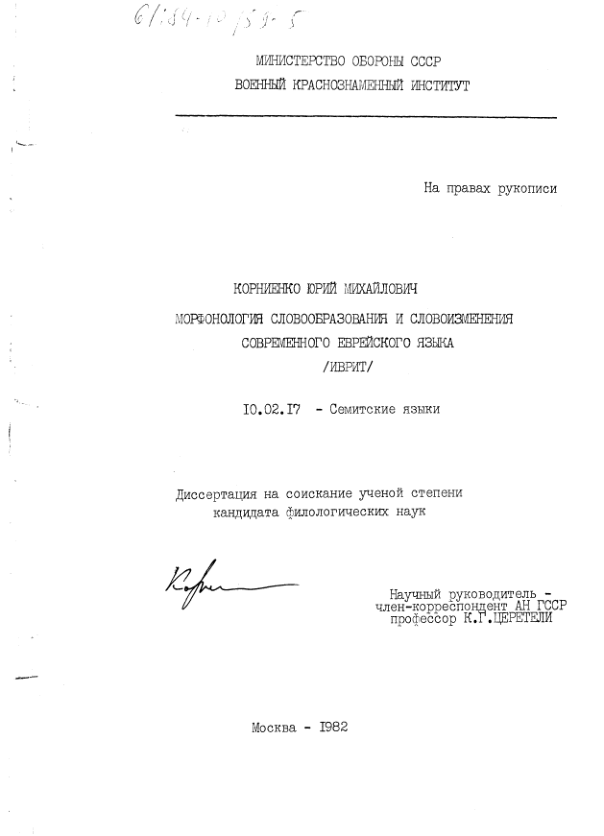

In [41]:
image(typewriter, 0, 1)

In [48]:
images = typewriter.load_page(0).get_image_info()
images

[{'bbox': (0.0, 0.0, 603.1199951171875, 835.9199829101562),
  'bpc': 1,
  'colorspace': 1,
  'cs-name': 'DeviceGray',
  'height': 3483,
  'number': 0,
  'size': 20964,
  'transform': (603.1199951171875, 0.0, -0.0, 835.9199829101562, 0.0, 0.0),
  'width': 2513,
  'xres': 96,
  'yres': 96}]

In [49]:
typewriter.load_page(0).get_text()

''

In [78]:
typewriter.load_page(0).get_image_rects(typewriter.load_page(0).get_images()[0])

[Rect(0.0, 0.0, 603.1199951171875, 835.9199829101562)]

In [54]:
chaos = fitz.open(os.path.join(WORKING_DIR, 'chaos.PDF'))
chaos

Document('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/chaos.PDF')

In [58]:
chaos.load_page(0).get_text()

''

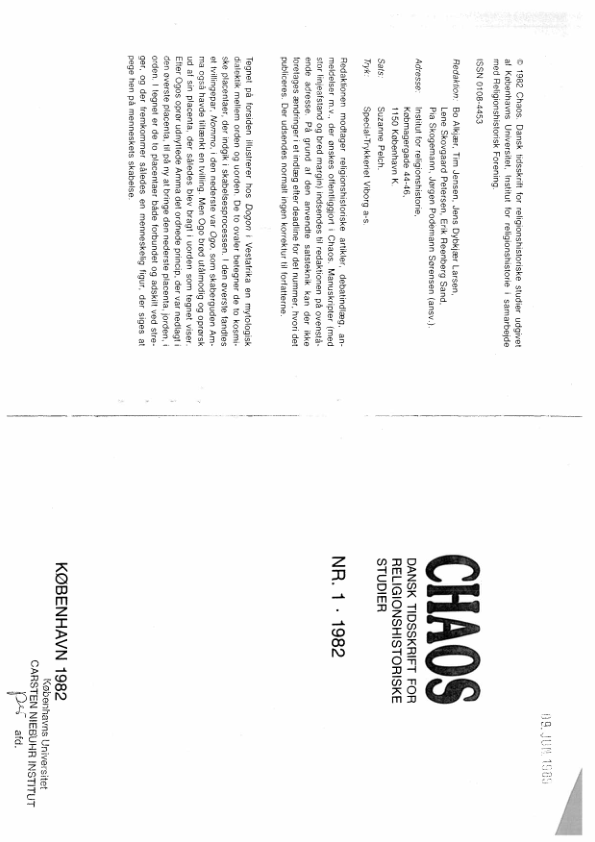

In [59]:
image(chaos, 0, 1)

In [79]:
chaos.load_page(0).get_image_info()

[{'bbox': (-1.45511794090271,
   -1.8822021484375,
   843.3448486328125,
   597.1577758789062),
  'bpc': 8,
  'colorspace': 1,
  'cs-name': 'DeviceGray',
  'height': 1248,
  'number': 0,
  'size': 36893,
  'transform': (844.7999877929688,
   0.0,
   -0.0,
   599.0399780273438,
   -1.45511794090271,
   -1.8822021484375),
  'width': 1760,
  'xres': 96,
  'yres': 96},
 {'bbox': (-1.45511794090271,
   -1.8822021484375,
   843.3448486328125,
   597.1577758789062),
  'bpc': 1,
  'colorspace': 0,
  'cs-name': 'None',
  'height': 2496,
  'number': 1,
  'size': 13482,
  'transform': (844.7999877929688,
   0.0,
   -0.0,
   599.0399780273438,
   -1.45511794090271,
   -1.8822021484375),
  'width': 3520,
  'xres': 96,
  'yres': 96}]

In [75]:
chaos.load_page(0).get_image_rects(chaos.load_page(0).get_images()[0])

[Rect(-1.45511794090271, -1.8822021484375, 843.3448486328125, 597.1577758789062)]

In [115]:
def total_image_area(page):
  """Returns the total area (in pixels) consumed by images that appear in PAGE,
  a fitz.Page object.
  Does not account for possible overlapping between images.
  """
  return sum(
      rect.getArea()
      for image in page.get_images()
      for rect in page.get_image_rects(image)
      )

In [117]:
total_image_area(chaos.load_page(0))

(1012137.9068276382, 0.0)

In [119]:
chaos.load_page(0).bound().getArea()

500990.0

In [67]:
chaos.load_page(0).bound()

Rect(0.0, 0.0, 595.0, 842.0)

In [64]:
bert.load_page(2).get_image_info()

[{'bbox': (345.05621337890625,
   94.40032196044922,
   367.180419921875,
   109.73558044433594),
  'bpc': 8,
  'colorspace': 3,
  'cs-name': 'DeviceRGB',
  'height': 133,
  'number': 3,
  'size': 1668,
  'transform': (22.124208450317383,
   0.0,
   -0.0,
   15.335260391235352,
   345.05621337890625,
   94.40032196044922),
  'width': 192,
  'xres': 96,
  'yres': 96},
 {'bbox': (365.1137390136719,
   94.74907684326172,
   387.7955017089844,
   110.08433532714844),
  'bpc': 8,
  'colorspace': 3,
  'cs-name': 'DeviceRGB',
  'height': 133,
  'number': 5,
  'size': 1704,
  'transform': (22.68175506591797,
   0.0,
   -0.0,
   15.335260391235352,
   365.1137390136719,
   94.74907684326172),
  'width': 197,
  'xres': 96,
  'yres': 96},
 {'bbox': (425.27667236328125,
   94.75542449951172,
   451.98150634765625,
   110.09068298339844),
  'bpc': 8,
  'colorspace': 3,
  'cs-name': 'DeviceRGB',
  'height': 133,
  'number': 7,
  'size': 1776,
  'transform': (26.704833984375,
   0.0,
   -0.0,
   15.3

In [66]:
bert.load_page(2).bound()

Rect(0.0, 0.0, 595.2760009765625, 841.8900146484375)

In [82]:
hebrew = fitz.open(os.path.join(WORKING_DIR, 'hebrew.pdf'))
hebrew.load_page(0).get_image_info()

[{'bbox': (0.0, 0.0, 589.6799926757812, 835.9199829101562),
  'bpc': 1,
  'colorspace': 1,
  'cs-name': 'DeviceGray',
  'height': 2323,
  'number': 0,
  'size': 44649,
  'transform': (589.6799926757812, 0.0, -0.0, 835.9199829101562, 0.0, 0.0),
  'width': 1638,
  'xres': 96,
  'yres': 96}]

In [83]:
hebrew.load_page(0).bound()

Rect(0.0, 0.0, 589.6799926757812, 835.9199829101562)

In [84]:
hebrew.load_page(0).get_text()

''

In [85]:
bibliography = fitz.open('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLa'
                         'ngTest/x Akkadian Linguistics Bibliography 2008.pdf')
bibliography.load_page(0).get_image_info()

[]

In [86]:
bibliography.get_page_text(0)

' \n \n1 \n \n2. AKKADIAN \n \n2.0 BIBLIOGRAPHY  \n[Cf. 0.1] \n \n“Accadica”, in “Saggio di bibliografia semitica 1976-1978”, by F. Vattioni, AION 1976-1992. [cf. 0.1.3]. \n “Accadien”, in  W.S. Lasor, A Basic Semitic Bibliography (Fuller Theological Seminary, Bibliographical Series \nI), Weaton, Ill. 1950. \n“Accadien”, in “Bibliographie sémitique, 1-9 [1939-1964]”, by S. Moscati et al., Or 1947-1963 [cf. 0.1.3]. \n“Akkadian”, in Bibliographie linguistique des Années / Linguistic Bibliography for the Year 1939-1947, 1948- , \nUtrecht(-Bruxelles)-Anvers 1940- [“Langues Chamito-Sémitiques / Hamito-Semitic Languages”]. \n“Akkadian”, by W.H. Römer in J.H. Hospers, ed., A Basic Bibliography for the Study of the Semitic Languages, 2 \nvols., Leiden 1973, I, pp. 365-383. \n“Akkadien. Sumérien”, in P.-É. Langevin, Bibliographie biblique... III: 1930-1983, Quebec 1985, pp. 338-365.  \n“Assyriologie. Register 1973-1976”, AfO 25, 1974-77, 360-482  [by Kh. Nasheh]: 26, 1978-79, 247-379 ; (by H. \

In [87]:
plato = fitz.open('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLa'
                  'ngTest/Plato-Opera_ Volume I_ Euthyphro, Apologia Soc'
                  'ratis, Crito, Phaedo, Cratylus, Sophista, Politicus, '
                  'Theaetetus (Oxford Classical Texts)-Oxford University'
                  ' Press, USA (1995).pdf')
plato.load_page(0).get_image_info()

[{'bbox': (0.0, 0.0, 393.6000061035156, 586.7999877929688),
  'bpc': 8,
  'colorspace': 1,
  'cs-name': 'Indexed(255,DeviceRGB)',
  'height': 4890,
  'number': 0,
  'size': 657558,
  'transform': (393.6000061035156, 0.0, -0.0, 586.7999877929688, 0.0, 0.0),
  'width': 3280,
  'xres': 96,
  'yres': 96}]

In [91]:
plato.load_page(1).get_image_info()

[{'bbox': (119.04000091552734,
   195.82989501953125,
   182.39999389648438,
   266.8699951171875),
  'bpc': 1,
  'colorspace': 1,
  'cs-name': 'DeviceGray',
  'height': 592,
  'number': 0,
  'size': 3274,
  'transform': (63.36000061035156,
   0.0,
   -0.0,
   71.04010009765625,
   119.04000091552734,
   195.82989501953125),
  'width': 528,
  'xres': 96,
  'yres': 96}]

In [90]:
plato.load_page(1).get_text()

'SCRIPTORUM CLASSICORUM \nBIBLIOTHECA OXONIENSIS \nΟΧΟΝΙΙ \nΕ TYPOGRAPHEO CLARENDONIANO \n'

In [92]:
plato.load_page(1).bound()

Rect(0.0, 0.0, 302.3999938964844, 505.0799865722656)

In [93]:
handbook = fitz.open('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLa'
                     'ngTest/Joseph-Janda--Handbook of Historical Linguisti'
                     'cs--Bibliography (OCR).pdf')
handbook.load_page(1).get_text()

'746 Bibliography\t\nBibliography 747\nAlekseev, M. E. (1994). Budukh. In Smeets 1994 (pp. 259-96).\nAlexander, Ronelle (1993). Remarks on the evolution of South Slavic prosodic systems,\nIn Robert A. Maguire and Alan Timberlake (eds), American Contributions to the Eleventh\nInternational Congress of Slavists, Bratislava, August-September 1993: Literature, Linguistics,\nPoetics (pp. 181-201). Columbus: Slavica.\nAllen, Cynthia (1980). Topics in Diachronic English Syntax. New York: Garland.\n\t\n(1995). Case Marking and Reanalysis: Grammatical Relations from Old to Early Modern\nEnglish. Oxford: Clarendon Press.\nAllen, W. Sidney (1951). Some prosodic aspects of retroflexion and aspiration in Sanskrit.\nBulletin of the School of Oriental and African Studies 13,939-46.\n\t\n(1976). The PIE aspirates: phonetic and typological factors in reconstruction. In\nAlphonse Juilland, Andrew M. Devine, and Laurence D. Stephens (eds) Linguistic\nStudies Offered to Joseph Greenberg (pp. 237-47). Sara

In [94]:
handbook.load_page(1).get_image_info()

[{'bbox': (0.0, 0.0, 1190.0, 841.0),
  'bpc': 1,
  'colorspace': 1,
  'cs-name': 'DeviceGray',
  'height': 3505,
  'number': 0,
  'size': 110271,
  'transform': (1190.0, 0.0, -0.0, 841.0, 0.0, 0.0),
  'width': 4959,
  'xres': 96,
  'yres': 96}]

In [100]:
pytesseract.image_to_string(image(handbook, 1, 1)) # 7s

' \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n  \n\n \n\n \n\n   \n\n   \n\n \n\n \n\n  \n\n \n\n   \n\n \n   \n\n \n\n \n\n \n\n \n\nPoetics (p. 181-2) Colbas eee\nAlles, Cyr (1980) Tp Engl Syne. New York: Ga\nAllen W.Sney (961 Some promdic aspects of tetlexon ane aspiration in Sans,\n1976). The PIE sepeates: phonetic and typolgial factors in reconstruction.\nAltenderet, Mork (199). Typoogial analysis. In Fagan 1996 (pp. 727,\nAlvare, Lois W Alvoree, Walter, Asoo, F, and Michel, LV. (980). Extraerestil\nAlvane, Walter (97) T. Rev andthe Cte of Doom. Princeton, Nf: Pineton Un\nAmsterdamsks, Olga (1987). Scho of Thought The Devopment of Ling\nKluwer Academie\n(1970, Towards typology of change: biercaing changes aod binary rates. a\n#7) Perceptual and conceptual ators in auctive innovations. n Jacek Psa\nsal). Morphological change towards spoley. In Fsisk 1980 (pp. 1-50\n— 0987. Fr ryt desnence In Martin Barisan Pas Ramat (ad)\n— (1989). Under

In [101]:
pytesseract.image_to_string(image(handbook, 1, 1.5)) # 12s

"746 Bibliography\n\nAlekseev, M. E. (1994). Budukh. In Smeets 1994 (pp. 259-96).\n\nAlexander, Ronelle (1993). Remarks on the evolution of South Slavic prosodic systems,\nIn Robert A. Maguire and Alan Timberlake (eds), American Contributions to the Eleventh\nInternational Congress of Slavists, Bratislava, August-September 1993: Literature, Linguistles,\nPoetics (pp. 181-201). Columbus: Slavica.\n\nAllen, Cynthia (1980). Topics in Diachronic English Syntax. New York: Garland,\n\n—— (1995). Case Marking and Reanalysis: Grammatical Relations from Old to Early Modern\nEnglish. Oxford: Clarendon Press.\n\nAllen, W. Sidney (1951). Some prosodic aspects of retroflexion and aspiration in Sanskeil,\nBulletin of the School of Oriental and ‘African Studies 13, 939-46\n\n— (1976). The PIE aspirates: phonetic and typological factors in reconstruction. In\nAlphonse Juilland, Andrew M. Devine, and Laurence D. Stephens (eds) Linguistic\nStudies Offered to Joseph Greenberg (pp. 237-47). Saratoga: Anma

In [102]:
pytesseract.image_to_string(image(handbook, 1, 1.25)) # 12s

" \n\n \n  \n \n  \n  \n \n \n \n \n    \n \n \n \n  \n  \n \n   \n \n \n  \n  \n \n \n \n  \n \n \n \n  \n \n \n \n  \n \n \n  \n  \n  \n \n \n  \n \n  \n   \n  \n  \n \n \n\n746 Bibliography\n\n \n\nAlekseev, M. E. (1994). Budukh. In Smeets 1994 (pp. 259-96),\n\nAlexander, Ronelle (1993). Remarks on the evolution of South Slavic prosodic systems,\nIn Robert A. Maguire and Alan Timberlake (eds), Ameriaam Contributions to the Eleventh\nInternational Congres of Stvists, Bratslaon, August-September 1998: Literatur, Linguists,\nPoetics (pp. 181-201). Columbus: Slavica,\n\nAllen, Cynthia (1980). Topics in Diachromie English Syntax. New York: Garland.\n\n— (1995). Case Marking and Reanalysis: Grammatical Relations from Old to Early Modern\nEnglish. Oxford: Clarendon Press.\n\nAllen, W. Sidney (1951). Some prosodic aspects of retroflexion and aspiration in Sanskrit,\nBulletin of the School of Oriental and African Studies 13, 939-46,\n\n— (1976). The PIE aspirates: phonetic and typological fa

In [99]:
pytesseract.image_to_string(image(handbook, 1, 2)) # 17s

" \n\n \n\n \n\n746 Bibliography\n\n \n\nAlekseev, M. E. (1994). Budukh, In Smeets 1994 (pp. 259-96).\n\nAlexander, Ronelle (1993). Remarks on the evolution of South Slavic prosodic systema,\nIn Robert A. Maguire and Alan Timberlake (eds), American Contributions to the Eleventh\nInternational Congress of Slavists, Bratislava, August-September 1993: Literature, Linguistics,\nPoetics (pp. 181-201). Columbus: Slavica.\n\nAllen, Cynthia (1980). Topics in Diachronic English Syntax. New York: Garland.\n\n—— (1995). Case Marking and Reanalysis: Grammatical Relations from Old to Early Modern\nEnglish. Oxford: Clarendon Press.\n\nAllen, W. Sidney (1951). Some prosodic aspects of retroflexion and aspiration in Sanskrit,\nBulletin of the School of Oriental and African Studies 13, 939-46.\n\n—— (1976). The PIE aspirates: phonetic and typological factors in reconstruction. In\nAlphonse Juilland, Andrew M. Devine, and Laurence D. Stephens (eds) Linguistic\nStudies Offered to Joseph Greenberg (pp. 23

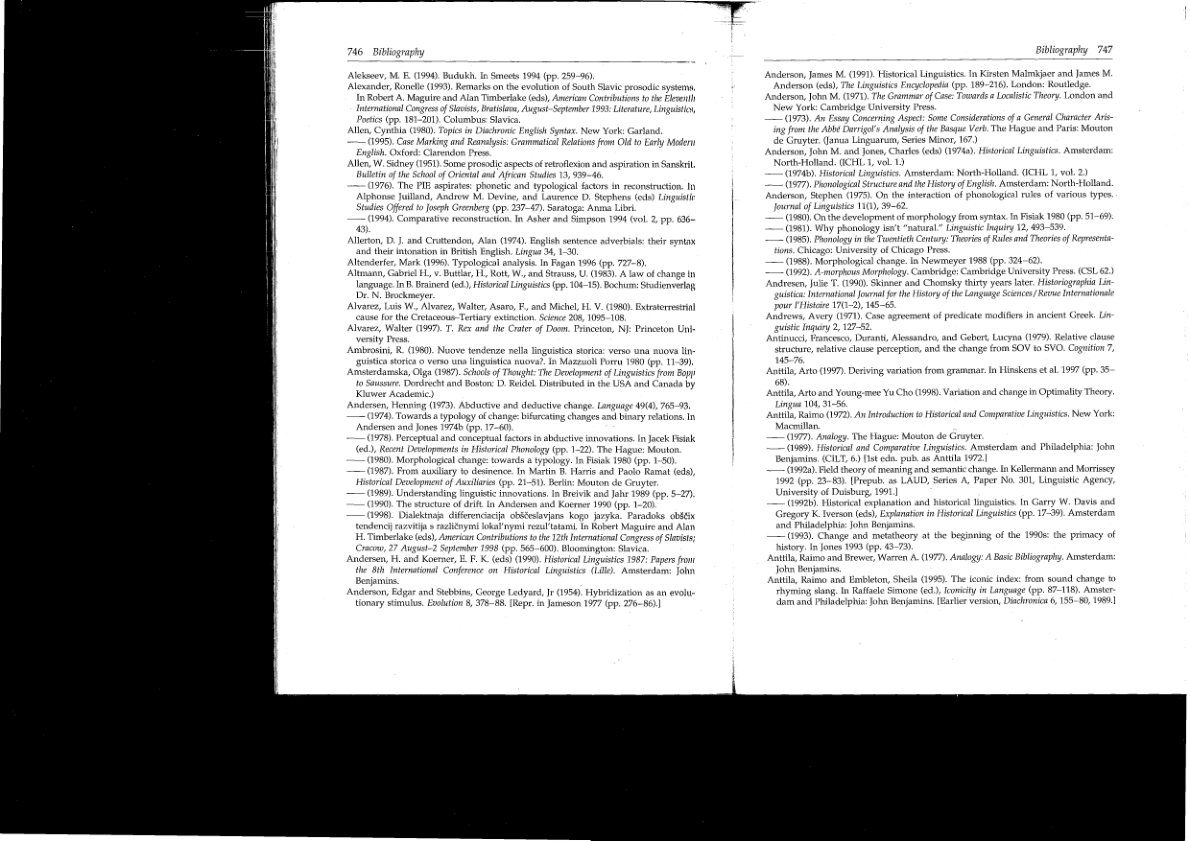

In [98]:
image(handbook, 1, 1)

In [106]:
sumer = fitz.open('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLa'
                     'ngTest/Sumer 50, 1999-2000.pdf')
image(sumer, 4)

Output hidden; open in https://colab.research.google.com to view.

In [110]:
sumer.load_page(4).get_text()

''

In [111]:
sumer.load_page(4).get_image_info()

[{'bbox': (0.0, 0.0, 1224.0, 831.0),
  'bpc': 8,
  'colorspace': 3,
  'cs-name': 'DeviceRGB',
  'height': 3464,
  'number': 0,
  'size': 1712358,
  'transform': (1224.0, 0.0, -0.0, 831.0, 0.0, 0.0),
  'width': 5100,
  'xres': 96,
  'yres': 96}]

In [112]:
sumer.load_page(4).bound()

Rect(0.0, 0.0, 1224.0, 831.0)

In [114]:
pytesseract.image_to_string(image(sumer, 4, 1)) # 8s

" \n\n \n\nae\n\n \n\nIraq, such as Chukha, Um Al-Agarib, Shmet, Bzekh ...and others, Another team\nis excavating the capital of the Kingdom of Eshnunna, known now by the name\nof (Tell Asmar) inthe Province of Diyala, in order to explore its buried\nantiquities\n\nBeside the excavations in the Sumerian cities, excavations are going on in a\nBabylonian city known now by the name of (Abu Antique) where a large\nnumber of clay tablets were discovered, which will throw light on the state of\nthis city in the Old Babylonian Period.\n\n \n\n \n\n \n\nAs the excavations are being, carried on in these parts of Iraq, other works are\ngoing on by the State Board of Antiquities in other different parts of the country\nTo the east of Tekrit, an excavating team had discovered in Tell Abu Ale\nMashaiil, levels. belonging to the old and middle Babylonian periods, and\nantiquities resembling those ones that had been discovered in the Babylonian\ncities in the middle parts of frag\n\n \n\nTogether wit

In [107]:
pytesseract.image_to_string(image(sumer, 4, 2)) # 14s

" \n\n \n\nIraq, such as Chukha, Um Al-Agarib, Shmet, Bzekh ...and others. Another team\nis excavating the capital of the Kingdom of Eshnunna, known now by the name\nof (Tell Asmar) in the Province of Diyala, in order to explore its buried\nantiquities.\n\nBeside the excavations in the Sumerian cities, excavations are going on in a\nBabylonian city known now by the name of (Abu Antique) where a large\nnumber of clay tablets were discovered, which will throw light on the state of\nthis city in the Old Babylonian Period.\n\nAs the excavations are being carried on in these parts of Iraq, other works are\ngoing on by the State Board of Antiquities in other different parts of the country.\nTo the east of Tekrit, an excavating team had discovered in Tell Abu Al-\nMasha'il, levels belonging to the old and middle Babylonian periods, and\nantiquities resembling those ones that had been discovered in the Babylonian\ncities in the middle parts of Iraq.\n\nTogether with the field works mentioned a

In [108]:
pytesseract.image_to_string(image(sumer, 4, 3)) # 14s

" \n\n \n\nIraq, such as Chukha, Um Al-Agarib, Shmet, Bzekh ...and others. Another team\nis excavating the capital of the Kingdom of Eshnunna, known now by the name\nof (Tell Asmar) in the Province of Diyala, in order to explore its buried\nantiquities.\n\nBeside the excavations in the Sumerian cities, excavations are going on in a\nBabylonian city known now by the name of (Abu Antique) where a large\nnumber of clay tablets were discovered, which will throw light on the state of\nthis city in the Old Babylonian Period.\n\nAs the excavations are being carried on in these parts of Iraq, other works are\ngoing on by the State Board of Antiquities in other different parts of the country.\nTo the east of Tekrit, an excavating team had discovered in Tell Abu Al-\nMasha'il, levels belonging to the old and middle Babylonian periods, and\nantiquities resembling those ones that had been discovered in the Babylonian\ncities in the middle parts of Iraq.\n\nTogether with the field works mentioned a

In [113]:
pytesseract.image_to_string(image(sumer, 4, 10)) # 32s

"Iraq, such as Chukha, Um Al-Agarib, Shmet, Bzekh ...and others. Another team\nis excavating the capital of the Kingdom of Eshnunna, known now by the name\nof (Tell Asmar) in the Province of Diyala, in order to explore its buried\nantiquities.\n\nBeside the excavations in the Sumerian cities, excavations are going on 1n a\nBabylonian city known now by the name of (Abu Antique) where a large\nnumber of clay tablets were discovered, which will throw light on the state of\nthis city in the Old Babylonian Period.\n\nAs the excavations are being carried on in these parts of Iraq, other works are\ngoing on by the State Board of Antiquities in other different parts of the country.\nTo the east of Tekrit, an excavating team had discovered in Tell Abu AI-\nMasha'il, levels belonging to the old and middle Babylonian periods, and\nantiquities resembling those ones that had been discovered in the Babylonian\ncities in the middle parts of Iraq.\n\nTogether with the field works mentioned above, othe

In [5]:
chaos = fitz.open(os.path.join(WORKING_DIR, 'chaos.PDF'))
chaos

Document('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/chaos.PDF')

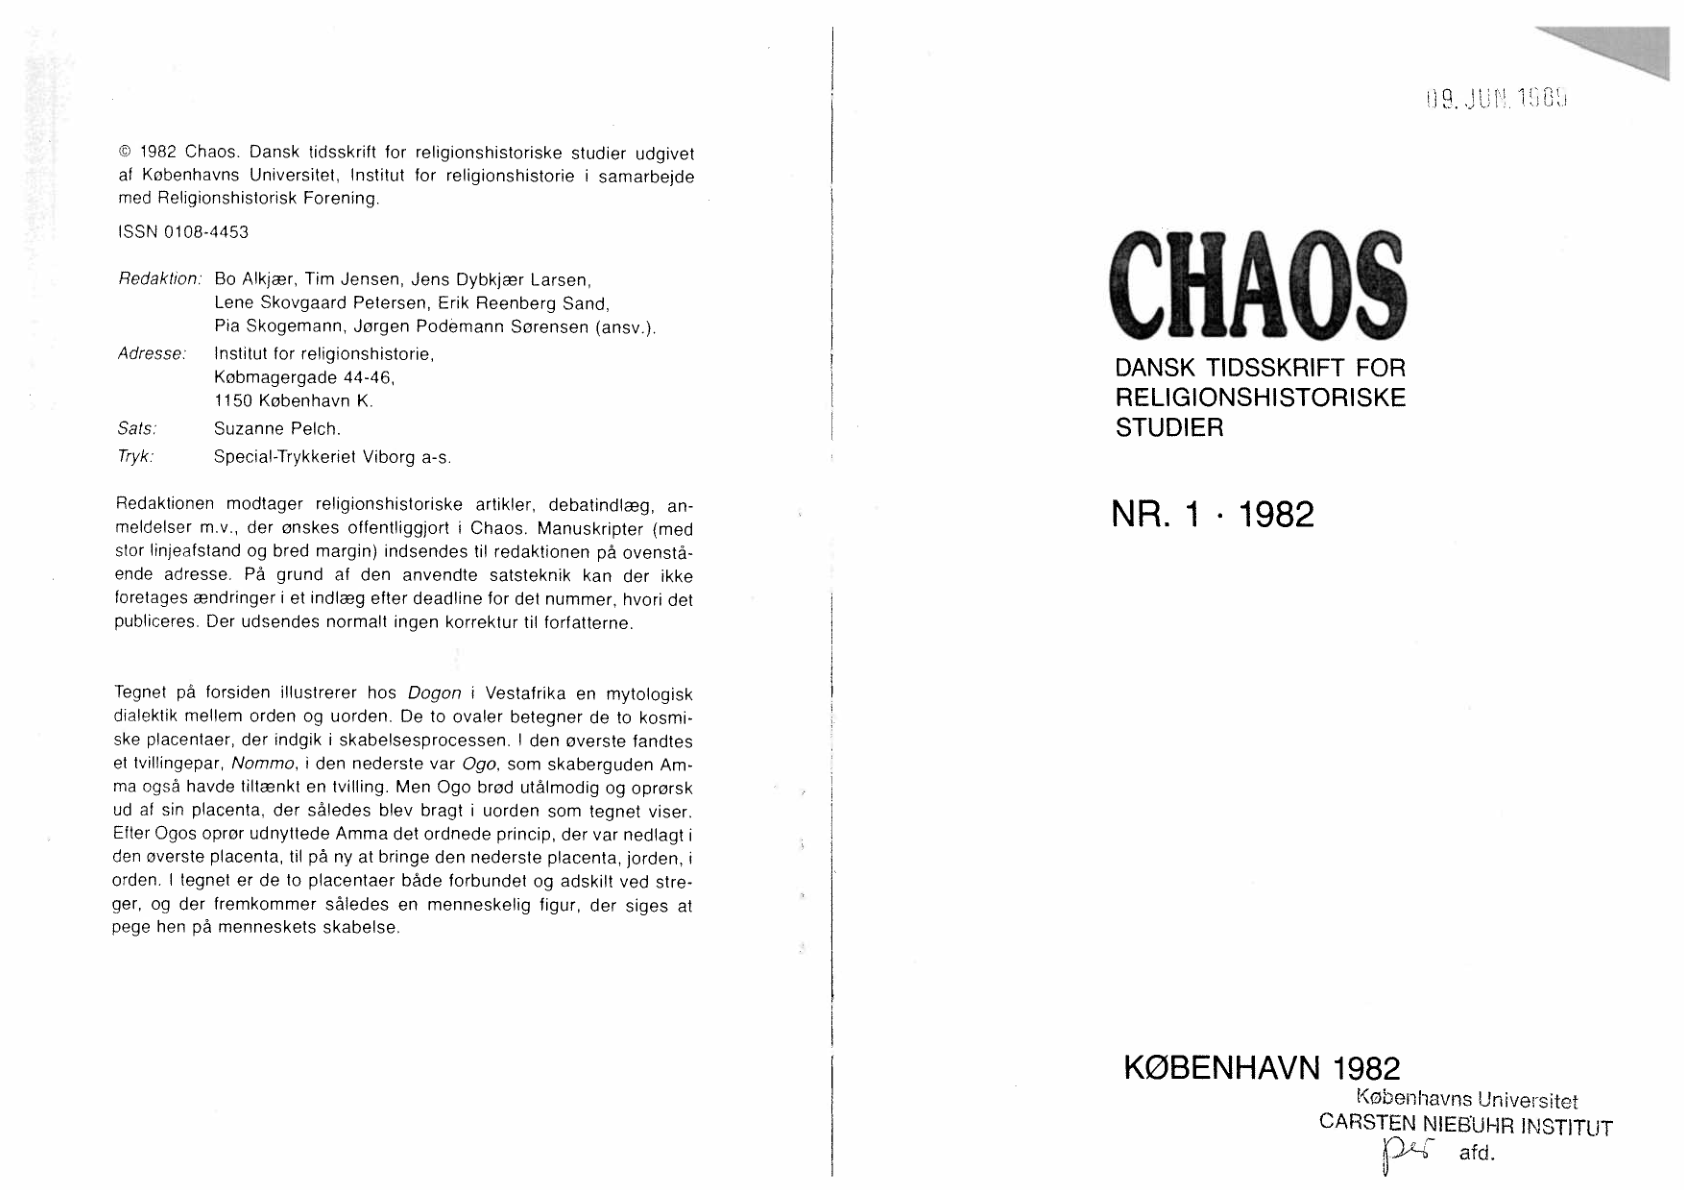

In [18]:
image(chaos, 0, 2).rotate(90, expand=True)

In [16]:
print(pytesseract.image_to_string(image(chaos, 0, 1)))

     

© 1982 Chaos, Danek
{1 Kobeinans Univers
od Raigionshstonsk Forening

ISSN 0108-4459

shit for saigonshisonske stuier udgivet
fe | samarbepe

 

Fedotton: Ba Aba, Tim Jenson, Jens Oyokies Larsen,
Lene Skovgaard Petersen, Era Rewrberg San
Pia Skogemann, Jorgen Podemann Serensen

 

 

 

Sats; Suzanna Pate,
yk ——_SpeciaTykkeret Viborg a,

age hen pd mennestets shabelse,

 

CHAOS

DANSK TIDSSKRIFT FOR
RELIGIONSHISTORISKE
STUDIER

NR. 1 - 1982

KOBENHAVN 1982
Kobenhavne Ur
(CARSTEN NIESUHR INSTITUT

ps

 

 

 



In [17]:
print(pytesseract.image_to_string(image(chaos, 0, 2)))

 

® 1982 Chaos. Dansk tidsskrift for religionshistoriske studier udgivet
af Kobenhavns Universitet, Institut for religionshistorie i samarbejde
med Religionshistorisk Forening.

 

 

  

ISSN 0108-4453

Redaktion: Bo Alkjzr, Tim Jensen, Jens Dybkjeer Larsen,
Lene Skovgaard Petersen, Erik Reenberg Sand,
Pia Skogemann, Jorgen Podemann Sorensen (ansv.).
Adresse: — nstitut for religionshistorie,
Kobmagergade 44-46,
1150 Kobenhavn K.
Sats. Suzanne Pelch.
Tryk. Special-Trykkeriet Viborg a-s.

Redaktionen modtager religionshistoriske artikler, debatindlaeg, an-
meldelser m.v., der onskes offentliggjort i Chaos. Manuskripter (med
stor linjeafstand og bred margin) indsendes ti! redaktionen pa ovensta-
ende adresse. Pa grund af den anvendte satsteknik kan der ikke
foretages aendringer i et indlaeg efter deadline for det nummer, hvori det
publiceres. Der udsendes normalt ingen korrektur til forfatterne

 

Tegnet pa forsiden illustrerer hos Dogon i Vestafrika en mytologisk
dialektik mellem orde

What have I learned?
* Magnification seems to improve accuracy when the images are generated from text (unsurprisingly), ~~but possibly not when rasters are being generated by rasters (because you cannot get more information than you started with).~~ I have found at least two examples in which scaling up an image leads to a dramatic improvement in accuracy with Tesseract. No idea why. Maybe PyMuPDF has some kind of subtle bug?
* It will be clear enough when it makes sense to use OCR. Use OCR if there are no large images -- regardless of whether there is text already (because we don't know where the text came from or whether it is accurate). What's a large image? Perhaps it should be at least half the page -- although we could require it to be at least 90% or the page or so, since the documents that are scanned seem to have images that are exactly the same size or almost exactly the same size as the page.

In [ ]:
current = !pwd
current = current[0]
current

In [7]:
!ls

adc.json  drive  sample_data


In [ ]:
%cd $WORKING_DIR
ids = !ls
len(ids)

In [ ]:
'0B9Ibqa26YXiRUlVrZkVLd2ZvQmM.pdf' in ids

In [ ]:
ids[:10]

In [ ]:
any('1dYAjO7U60dPHJ0sJKkRN8PoiXAwb5NQO'.lower() in id.lower() for id in ids)

In [ ]:
[id for id in ids if len(id) < 10]

In [ ]:
os.path.splitext('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/temp/1dYAjO7U60dPHJ0sJKkRN8PoiXAwb5NQO.pdf')[1]

## 2. Build a Compressed Representative Document

The objective here is to take a stratified sample of the pages in the large representative document.

## 3. Evaluate an OCR System

Here, I define a process for measuring _time_ and _overall accuracy_ for an OCR system.